# What have I been doing?

In [ ]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
from copy import deepcopy
from tqdm.notebook import tqdm
from datetime import datetime

In [3]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [263]:
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (7.2, 4.0)

In [194]:
%config InlineBackend.figure_format = "retina"
sns.set_palette("colorblind")

In [7]:
public_access_token = os.environ["GH_PUBLIC_ACCESS_TOKEN"]
# g = Github(public_access_token)

In [8]:
def extract_report(api_token, workspace_id, start_date, end_date, project_id=None, page=1):
    url_details = (
        "https://api.track.toggl.com/reports/api/v3/workspace"
        f"/{workspace_id}/search/time_entries"
    )
    
    params = {
        "start_date": start_date,
        "end_date": end_date,
#         "page": page,
    }
    
    if project_id is not None:
        dict_pid = {"project_ids": project_id}
        params = {**params, **dict_pid}
    
    r = requests.get(url_details, params=params, auth=(api_token, "api_token"))
    r.raise_for_status()
    
    return r

## Time

In [9]:
api_token = os.environ["TOGGL_API_TOKEN"]
password = os.environ["TOGGL_PASSWORD"]
mail = "g.duran@me.com"

In [10]:
headers = {
    "Content-Type": "application/json"
}

In [11]:
url_me = "https://api.track.toggl.com/api/v9/me"
r = requests.get(url_me, headers=headers, auth=(mail, password))
data = r.json()
print(data["fullname"], data["created_at"])

Gerardo Durán 2015-04-28T02:55:50.05493Z


In [12]:
url_workspace = "https://api.track.toggl.com/api/v9/workspaces"
r = requests.get(url_workspace, headers=headers, auth=(mail, password))

In [13]:
list_workspaces = r.json()
list_workspaces
for workspace_data in list_workspaces:
    workspace_name = workspace_data["name"]
    workspace_id = workspace_data["id"]
    
    print(f"{workspace_name:>10}: id-{workspace_id}")

  Personal: id-921814
      QMUL: id-4657976
  QMUL-PhD: id-5608619


In [14]:
workspace_id = 5608619

In [15]:
url_projects = f"https://api.track.toggl.com/api/v9/workspaces/{workspace_id}/projects"
r = requests.get(url_projects, headers=headers, auth=(mail, password))

In [16]:
list_projects = r.json()

In [17]:
project_info = {}
for project_data in list_projects:
    project_data = deepcopy(project_data)
    name = project_data.pop("name")
    project_info[name] = project_data
    
project_info.keys()

dict_keys(['emails', 'learn', 'Logs', 'LTCC', 'managerial', 'Man-internship', 'meeting', 'open source', 'paper-review', 'papers', 'Qincubator', 'research', 'talks', 'teaching', 'writings'])

In [18]:
project_map = {
    project_info[key]["id"]: key
    for key in project_info
}
project_map

{174173399: 'emails',
 176470513: 'learn',
 195059514: 'Logs',
 175474345: 'LTCC',
 176401736: 'managerial',
 181266137: 'Man-internship',
 174475285: 'meeting',
 187607086: 'open source',
 207735880: 'paper-review',
 174403112: 'papers',
 178144820: 'Qincubator',
 172689542: 'research',
 177440188: 'talks',
 179388476: 'teaching',
 207241276: 'writings'}

In [27]:
def extract_report(api_token, workspace_id, start_date, end_date, project_id=None, first_row=1):
    url_details = (
        "https://api.track.toggl.com/reports/api/v3/workspace"
        f"/{workspace_id}/search/time_entries"
    )
    
    params = {
        "start_date": start_date,
        "end_date": end_date,
        "order_dir": "ASC",
        "first_row_number": first_row,
    }
        
    if project_id is not None:
        dict_pid = {"project_ids": project_id}
        params = {**params, **dict_pid}
    
    r = requests.post(url_details, json=params, auth=(api_token, "api_token"))
    r.raise_for_status()
    
    return r

In [90]:
workspace_id = 5608619
start_date = "2024-01-01"
end_date = "2024-12-31"


year_init = 2021
year_end = 2025
years = list(range(year_init, year_end + 1))

all_vals = []
for year in years:
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    first_row = 1
    key_next = "X-Next-Row-Number"
    while True:
        r = extract_report(api_token, workspace_id, start_date, end_date, first_row=first_row)
        vals = r.json()
        headers = r.headers
        all_vals.extend(vals)
        if key_next not in headers:
            break
        else:
            first_row = int(headers[key_next])
        sleep(1)
        print(f"At row {first_row:04} | {year}", end="\r")
    # all_vals = [element for collection in all_vals for element in collection]

At row 51 | 202524

In [93]:
all_vals[0]

{'user_id': 1670359,
 'username': 'Gerardo Durán',
 'project_id': 172689542,
 'task_id': None,
 'billable': False,
 'description': 'Creating issues',
 'tag_ids': [],
 'billable_amount_in_cents': None,
 'hourly_rate_in_cents': None,
 'currency': 'USD',
 'time_entries': [{'id': 2129046546,
   'seconds': 1079,
   'start': '2021-08-13T07:26:06+01:00',
   'stop': '2021-08-13T07:44:05+01:00',
   'at': '2021-08-13T06:44:05+00:00',
   'at_tz': '2021-08-13T07:44:05+01:00'}],
 'row_number': 1}

In [94]:
data = pd.DataFrame([{
    "project_id": entry["project_id"],
    "description": entry["description"],
    "seconds": entry["time_entries"][0]["seconds"],
    "start": pd.Timestamp(entry["time_entries"][0]["start"]),
    "stop": pd.Timestamp(entry["time_entries"][0]["stop"]),
} for entry in all_vals])
data = data.dropna()
data["project"] = data["project_id"].apply(lambda x: project_map[int(x)])
data["start_utc"] = pd.to_datetime(data["start"], utc=True)
data = data.set_index("start_utc")
data = data.drop_duplicates()
data.describe()

,project_id,seconds
count,5.335000e+03,5335.000000
mean,1.746233e+08,3921.995876
std,4.914316e+06,2955.611188
min,1.726895e+08,0.000000
25%,1.726895e+08,1721.500000
50%,1.726895e+08,3438.000000
75%,1.744753e+08,5378.500000
max,2.077359e+08,30434.000000


# Top-to-bottom: how much did I work?

Text(0, 0.5, 'daily hours')

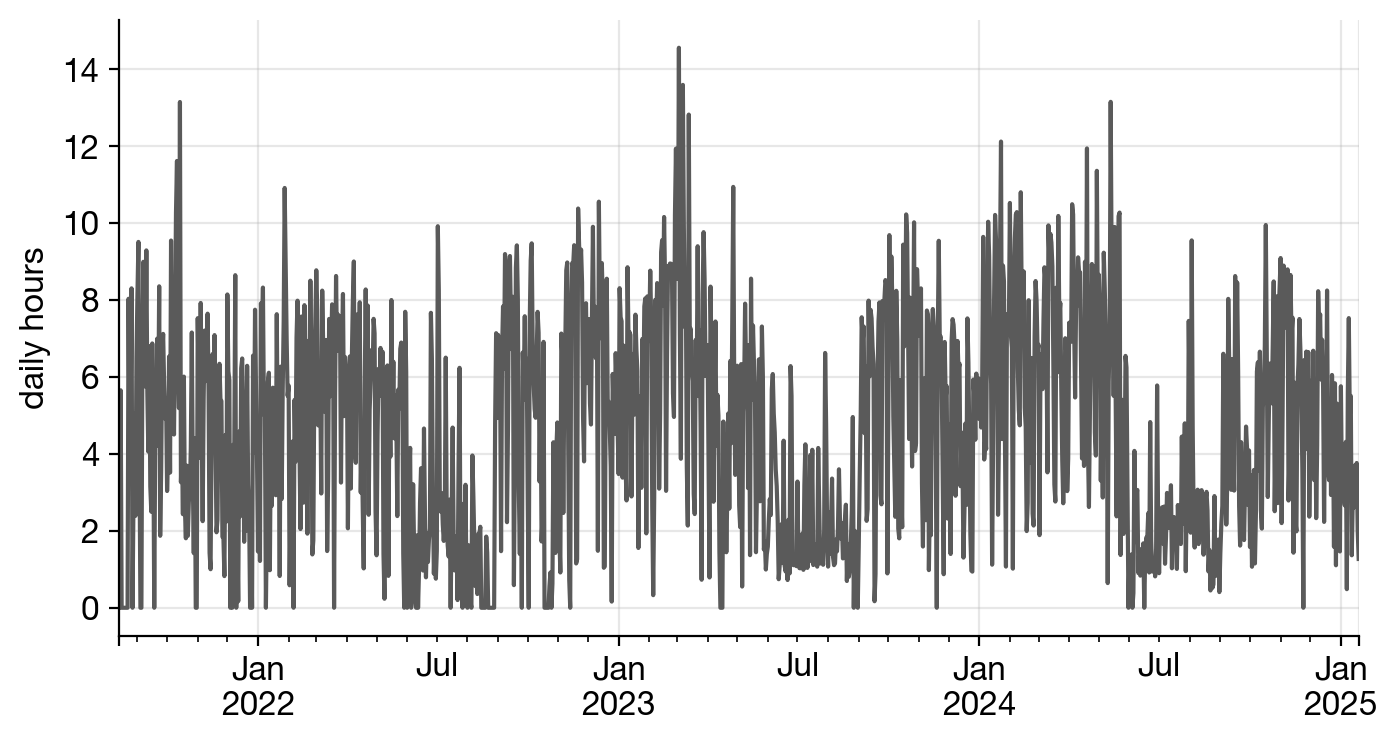

In [325]:
fig, ax = plt.subplots(figsize=(8, 4))
(
    data["seconds"]
    .resample("D").sum().div(60 ** 2)
).plot(c="#5A5A5A")
plt.grid(alpha=0.3)
plt.xlabel("")
plt.ylabel("daily hours")

Text(0, 0.5, 'weekly hours')

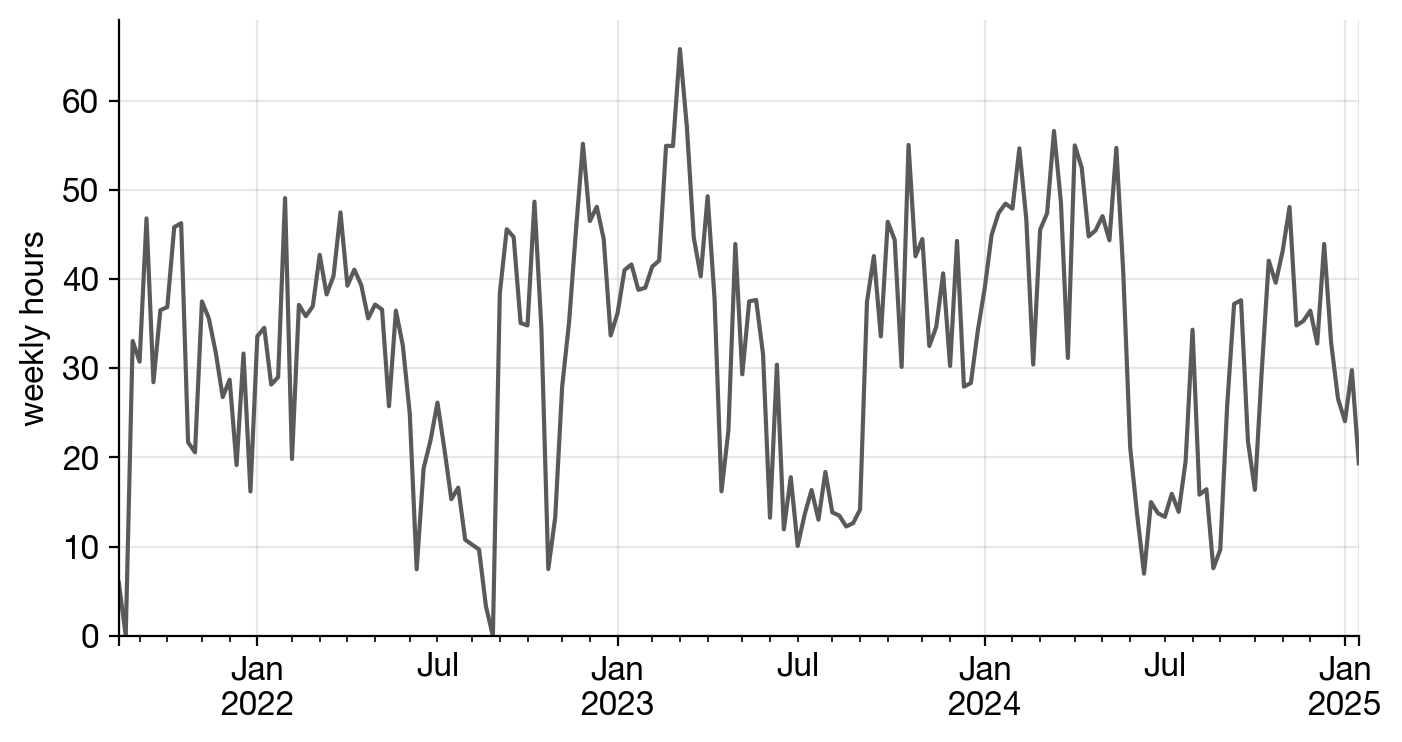

In [282]:
fig, ax = plt.subplots(figsize=(8, 4))
(
    data["seconds"]
    .resample("1W").sum().div(60 ** 2)
).plot(c="#5A5A5A")
plt.grid(alpha=0.3)
plt.xlabel("")
plt.ylim(bottom=0.0)
plt.ylabel("weekly hours")

In [267]:
def create_date_indices(dates):
    index_dates = []
    for entry in dates:
        month = entry.month
        day = 28 if (entry.day == 29) and (month == 2) else entry.day
        index_dates.append(datetime(2021, month, day))
    return index_dates

## Monthly

In [268]:
palette = sns.color_palette("viridis", n_colors=3)
palette = plt.cm.viridis(np.linspace(0, 1, len(years)))

In [279]:
plt.rcParams["font.family"] = ["Helvetica Neue"]

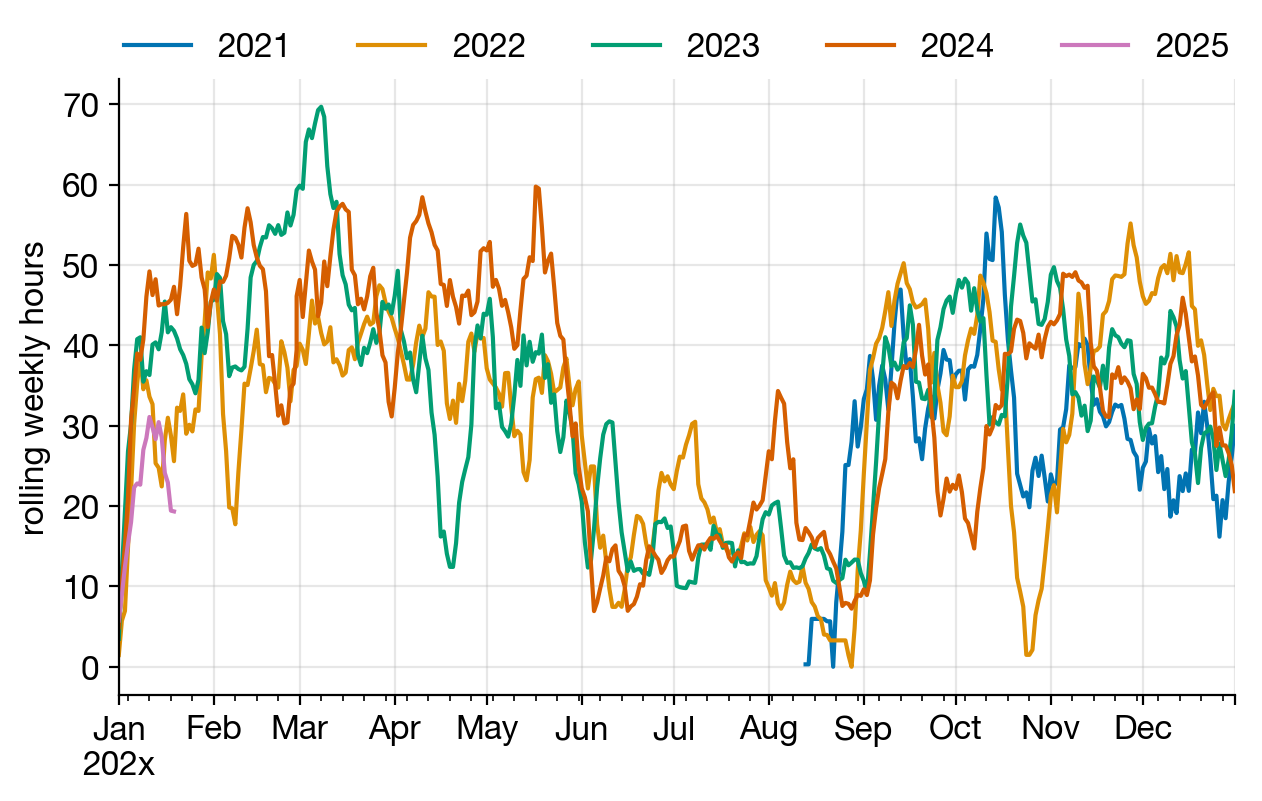

In [353]:
yearly_data = {}

for year, color in zip(years, palette):
    data_year_seconds = data.loc[str(year)]["seconds"].resample("1D").sum() / (60 * 60)
    index_new = create_date_indices(data_year_seconds.index)
    data_year_seconds.index = index_new
    data_year_seconds.rolling("7D").sum().plot(label=year)
    yearly_data[year] = data_year_seconds
plt.legend(ncol=5, bbox_to_anchor=(0.5,1.05), loc="center", frameon=False)
plt.ylabel("rolling weekly hours")
xpos, xticks = plt.xticks()
xticks[0].set_text("Jan\n202x")
plt.xticks(xpos, xticks)
plt.grid(alpha=0.3)

yearly_data = pd.DataFrame(yearly_data)

In [738]:
yearly_data_rolling = yearly_data.rolling("7D").sum()

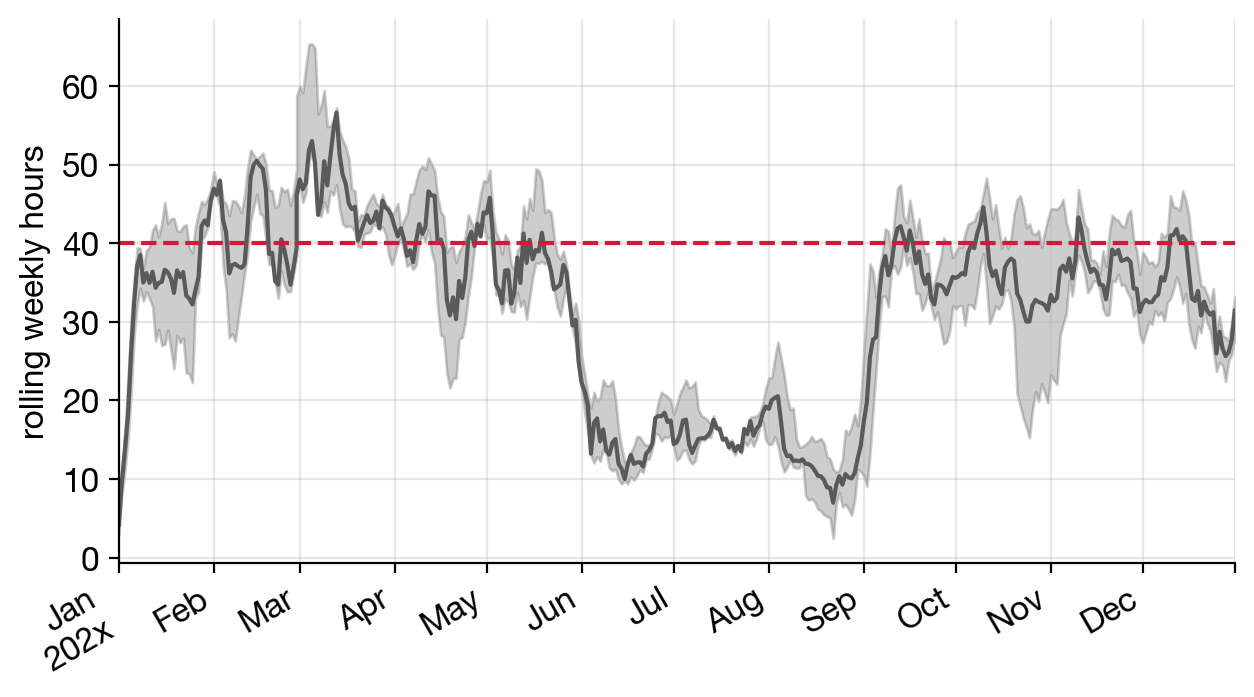

In [739]:
color = "#5A5A5A"
fig, ax = plt.subplots()
yearly_data_rolling.median(axis=1).plot(c=color)
ax.fill_between(
    yearly_data_rolling.index,
    yearly_data_rolling.quantile(0.25, axis=1), yearly_data_rolling.quantile(0.75, axis=1), alpha=0.3, color=color
)
plt.ylabel("rolling weekly hours")
plt.grid(alpha=0.3)
plt.xlim(left=xpos[0], right=xpos[-1])
plt.axhline(y=40, c="crimson", linestyle="--")
plt.xticks(xpos, xticks);

In [740]:
year_summary = yearly_data.copy()
year_summary.index = [entry.strftime("%b") for entry in year_summary.index]
year_summary = year_summary.reset_index().rename({"index": "month"}, axis=1)
year_summary = year_summary.melt("month").dropna()

Text(0, 0.5, 'hours')

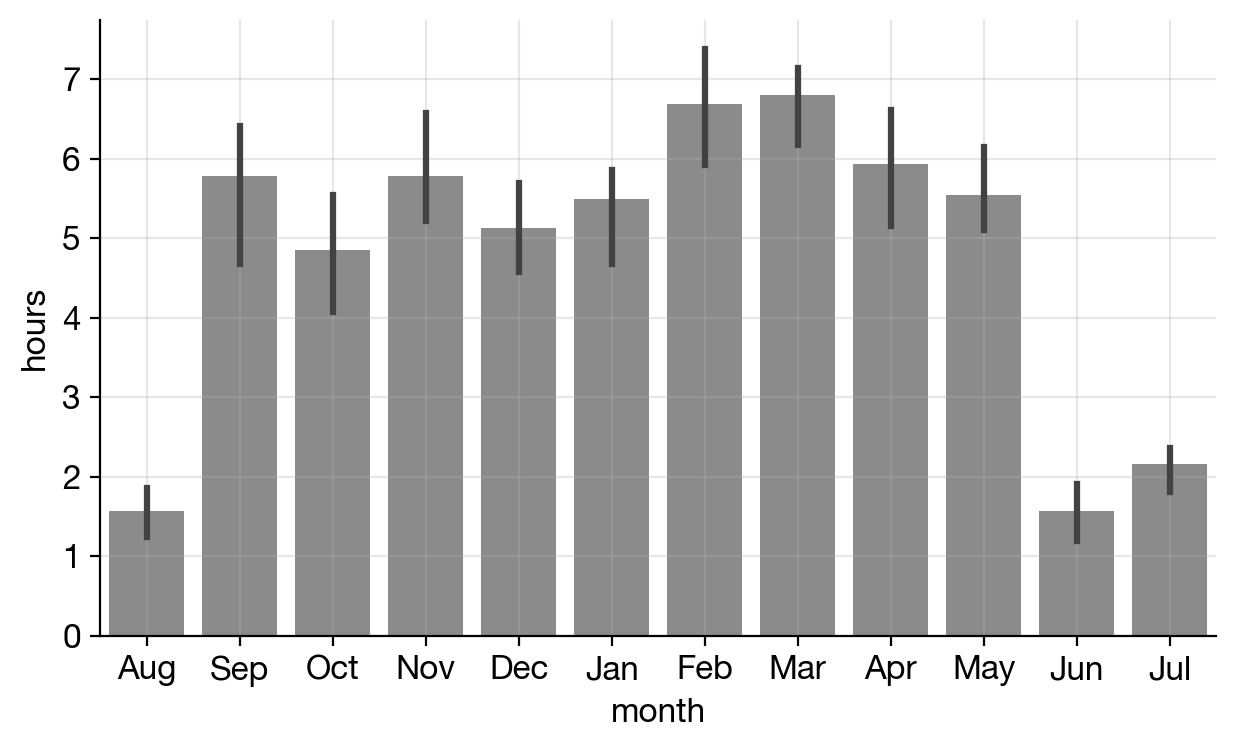

In [741]:
ordering = year_summary.groupby("month")["value"].median().sort_values(ascending=False).index

sns.barplot(
    x="month", y="value", data=year_summary, estimator="median", color=color, alpha=0.7
)
plt.grid(alpha=0.3)
plt.ylabel("hours")

## Weekly 

In [742]:
data_weekly = pd.DataFrame(data["seconds"].copy())
data_weekly.index.name = "start"

data_weekly = data_weekly.resample("D").apply(["mean", "sum"])["seconds"]
data_weekly["weekday"] = [entry.strftime("%a") for entry in data_weekly.index]
# data_weekly["weekday-num"] = [w if ((w := entry.weekday()) != 0) else 7 for entry in data_weekly.index]
data_weekly["weekday-num"] = [entry.weekday() for entry in data_weekly.index]
data_weekly["hour"] = [entry.hour for entry in data_weekly.index]
data_weekly["year"] = [entry.year for entry in data_weekly.index]

data_weekly = data_weekly.dropna()

data_weekly["day"] = data_weekly["sum"] / 60 ** 2

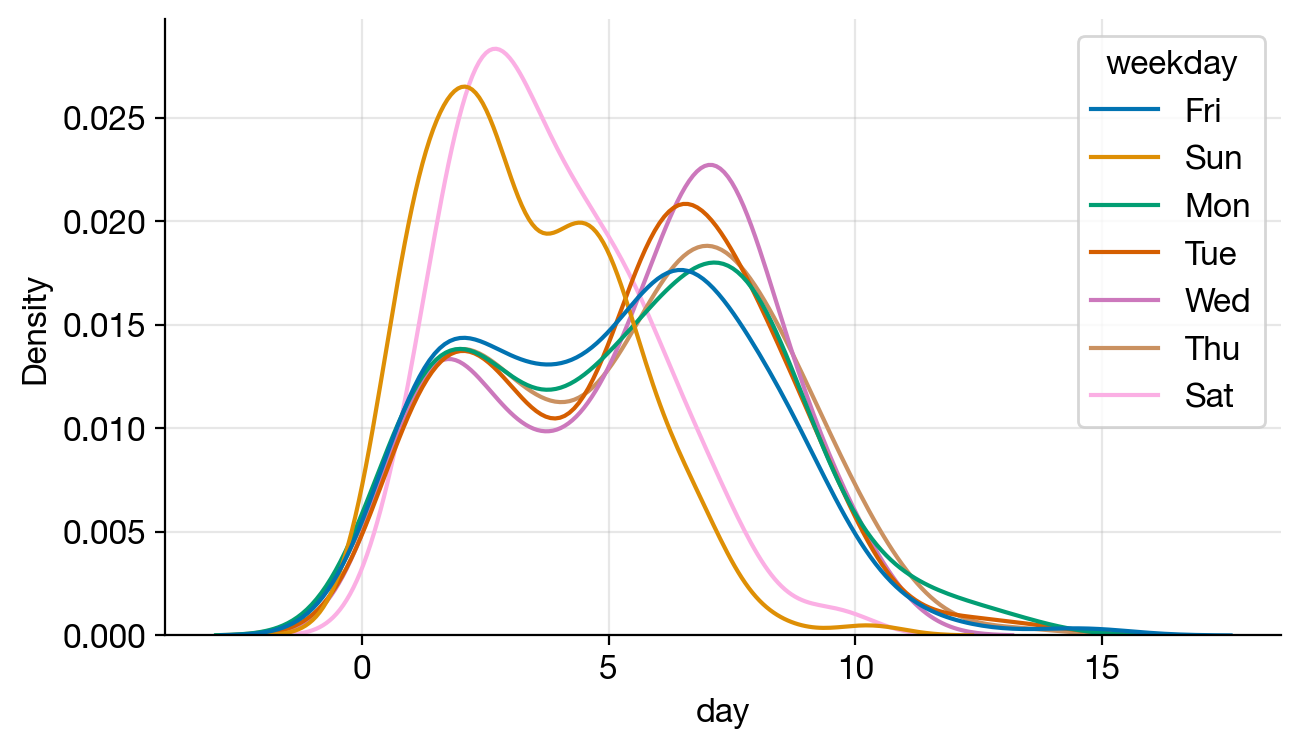

In [743]:
sns.kdeplot(x="day", data=data_weekly, hue="weekday")
plt.grid(alpha=0.3)

In [729]:
ordering = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

In [730]:
data_weekly.groupby("weekday")["day"].describe()[["25%", "50%", "75%"]].round(3).loc[ordering]

,25%,50%,75%
weekday,,,
Mon,2.679,5.702,7.617
Tue,2.717,5.895,7.506
Wed,2.926,6.216,7.469
Thu,2.732,5.997,7.645
Fri,2.621,5.457,7.132
Sat,2.278,3.574,5.163
Sun,1.768,2.909,4.732


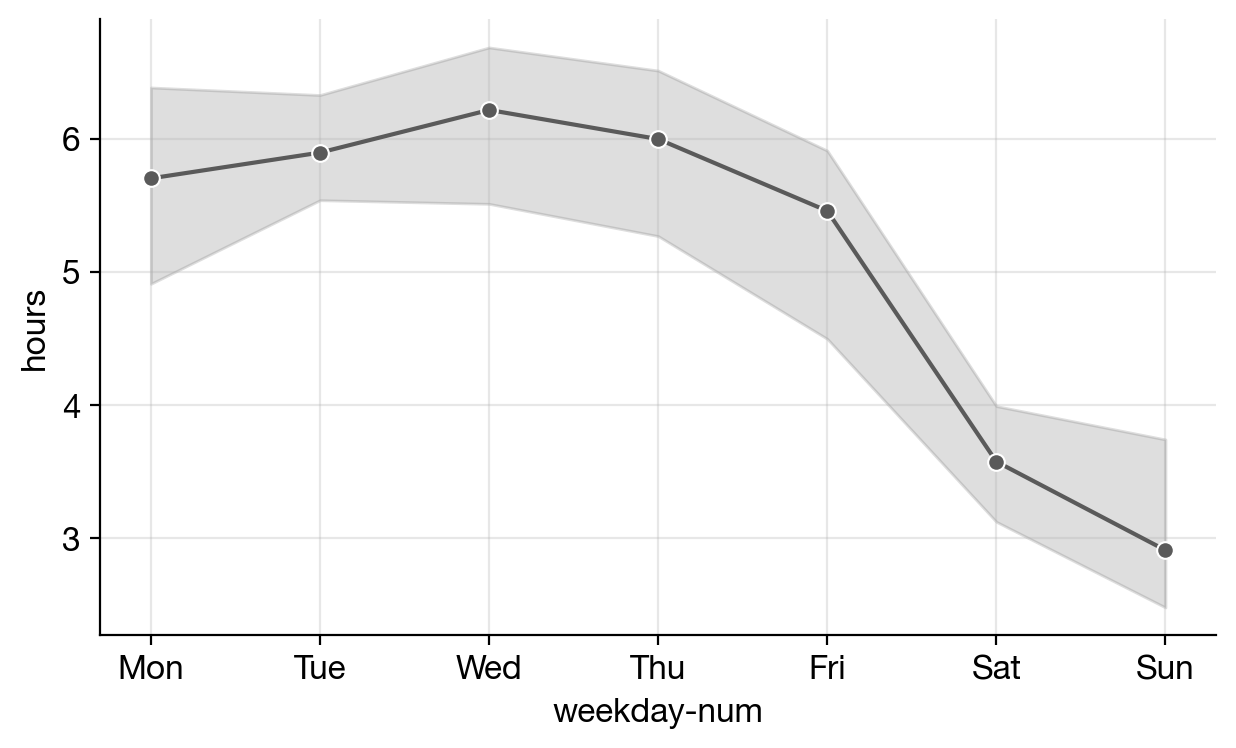

In [731]:
sns.lineplot(x="weekday-num", y="day", data=data_weekly, c=color, estimator="median", marker="o")
plt.xticks(np.arange(7), ordering);
plt.ylabel("hours")
plt.grid(alpha=0.3)

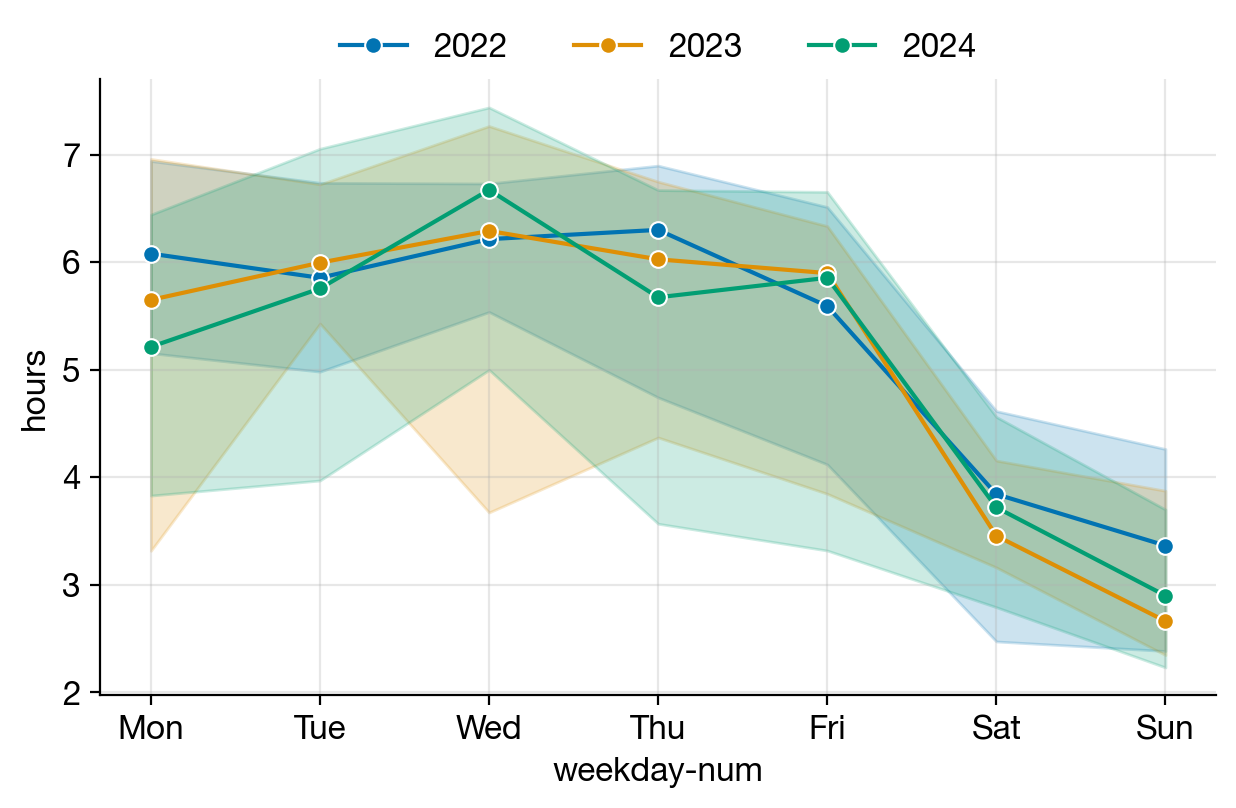

In [732]:
sns.lineplot(
    x="weekday-num", y="day", data=data_weekly.query("year not in [2021, 2025]"),
    hue="year", estimator="median", marker="o",
    palette="colorblind"
)
plt.ylabel("hours")
plt.legend(ncol=5, bbox_to_anchor=(0.5,1.05), loc="center", frameon=False)
plt.xticks(np.arange(7), ordering);
plt.grid(alpha=0.3)

## Daily

In [899]:
weekdays =  ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

In [900]:
data_daily = pd.DataFrame(data[["seconds", "project", "description"]].copy())
data_daily.index.name = "start"

data_daily = data_daily.reset_index()
data_daily["month"] = [entry.month for entry in data_daily["start"]]

tslice = [entry.month in [12, 1] for entry in data_daily["start"]]
data_daily.loc[tslice, "start"] = data_daily["start"][tslice] - pd.Timedelta(hours=6)

data_daily = data_daily.set_index("start")

In [901]:
data_daily["hour"] = [entry.hour for entry in data_daily.index]
data_daily["weekday"] = [entry.strftime("%a") for entry in data_daily.index]
data_daily["weekday-num"] = [entry.weekday() for entry in data_daily.index]

In [902]:
data_daily.query("hour==13").loc[data_daily.query("hour==13")["seconds"].idxmax()]

seconds             17770
project          research
description    SharpBayes
month                  11
hour                   13
weekday               Mon
weekday-num             0
Name: 2022-11-28 13:47:55+00:00, dtype: object

<Axes: xlabel='weekday-num', ylabel='hour'>

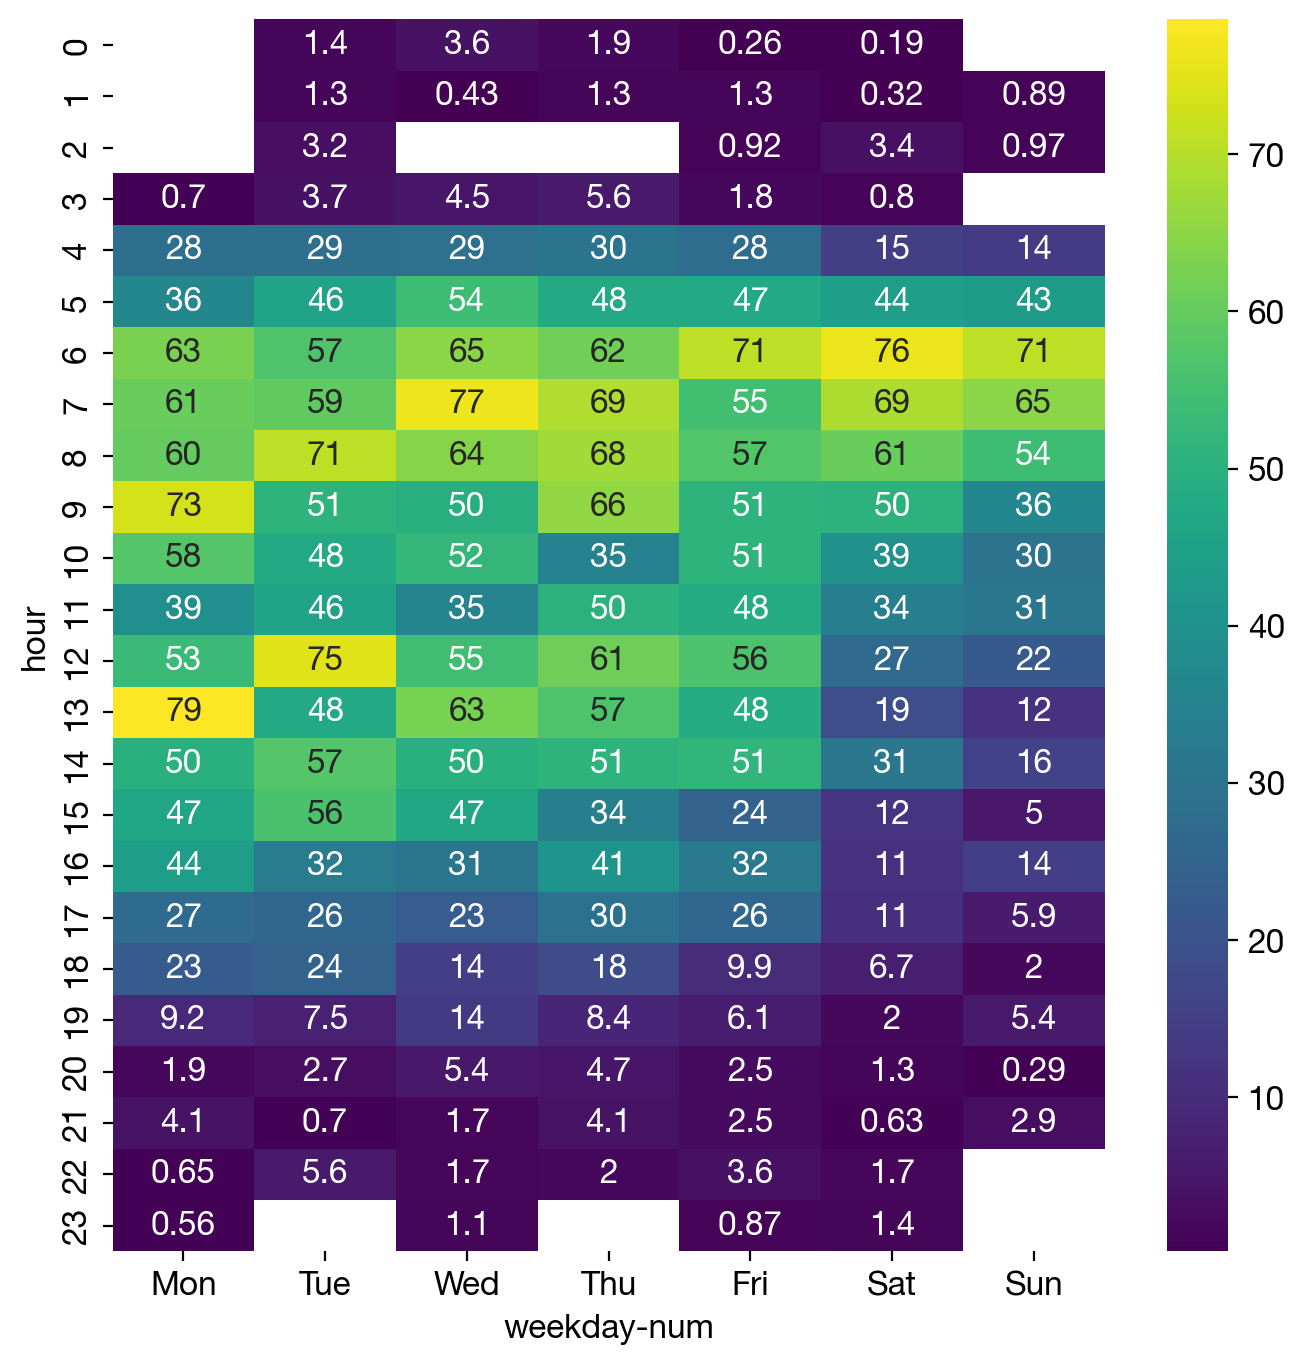

In [939]:
summary_daily = (
    data_daily
    .query("month not in [12,1]")
    .pivot_table(index="hour", columns="weekday-num", values="seconds", aggfunc="sum")
)

summary_daily = summary_daily / (60 ** 2)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(summary_daily, cmap="viridis", annot=True, ax=ax, xticklabels=weekdays)

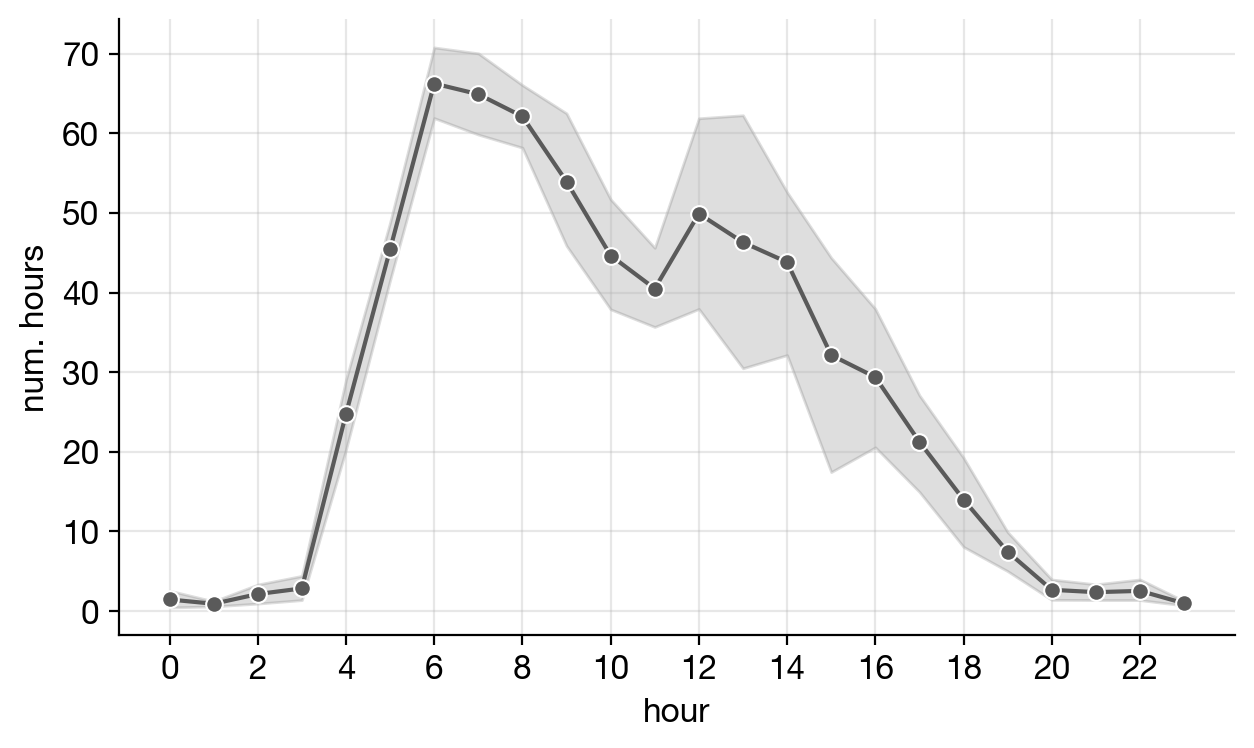

In [1217]:
sns.lineplot(x="hour", y="value", data=summary_daily.reset_index().melt("hour"), color=color, marker="o")
plt.xticks(np.arange(0, 24, 2))
plt.ylabel("num. hours")
plt.grid(alpha=0.3)

In [1157]:
x = summary_daily.index
y = summary_daily.columns
Z = summary_daily.values

X, Y = np.meshgrid(x, y)

x = X.ravel()
y = Y.ravel()
z = Z.ravel()
z[np.isnan(z)] = 0.0
bottom = 0.0

norm = plt.Normalize(z.min(), z.max())
colors = plt.cm.viridis(norm(z)) 

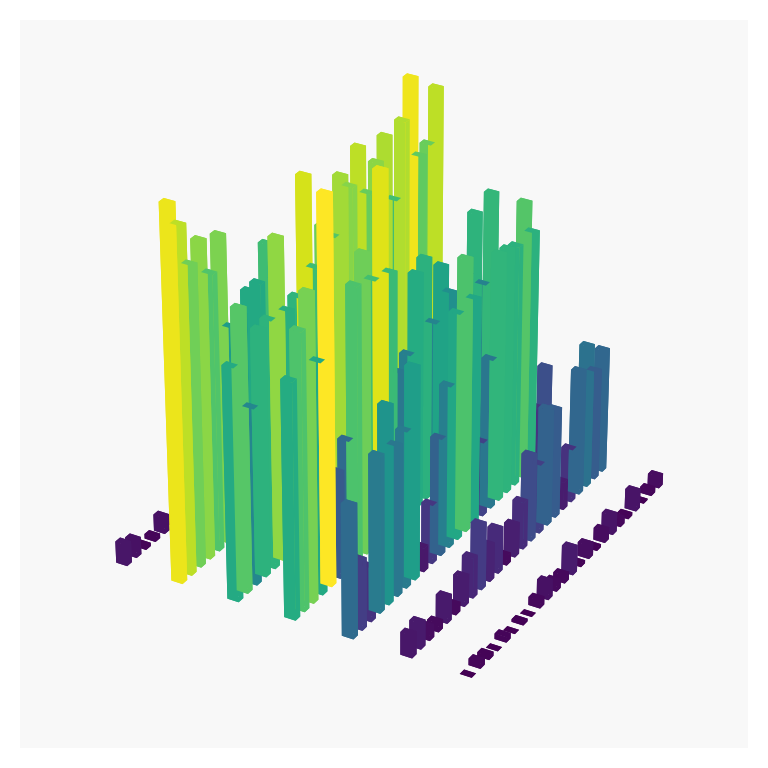

In [1237]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.bar3d(x, y, 0.0, 0.5, 0.2, z, color=colors, shade=False)
max_value = np.nanmax(z)
ax.set_zlim(0, max_value * 0.8)
ax.view_init(azim=30, elev=30)
plt.gca().patch.set_facecolor('#ddd3')
plt.tight_layout()
plt.axis("off");

In [1125]:
rows = summary_daily.index
cols = summary_daily.columns
x, y = np.meshgrid(np.arange(len(rows)), np.arange(len(cols)))

# Flatten the x, y, and values for bar plot
x_flat = x.flatten()
y_flat = y.flatten()

In [1126]:
norm = plt.Normalize(z.min(), z.max())
colors = plt.cm.viridis(norm(z))  # Use the 'viridis' colormap

In [1127]:
from mpl_toolkits.mplot3d import Axes3D

def scale_3d(ax, x_scale, y_scale, z_scale, factor=0.62):

    scale=np.diag([x_scale, y_scale, z_scale, 1.0])
    scale=scale*(1.0/scale.max())
    scale[3,3]=factor

    def short_proj():
        return np.dot(Axes3D.get_proj(ax), scale)
    return short_proj

def style3d(ax, x_scale, y_scale, z_scale):
    """
    See https://stackoverflow.com/questions/11448972/changing-the-background-color-of-the-axes-planes-of-a-3d-plot
    """
    plt.gca().patch.set_facecolor('white')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    ax.get_proj = scale_3d(ax, x_scale, y_scale, z_scale)

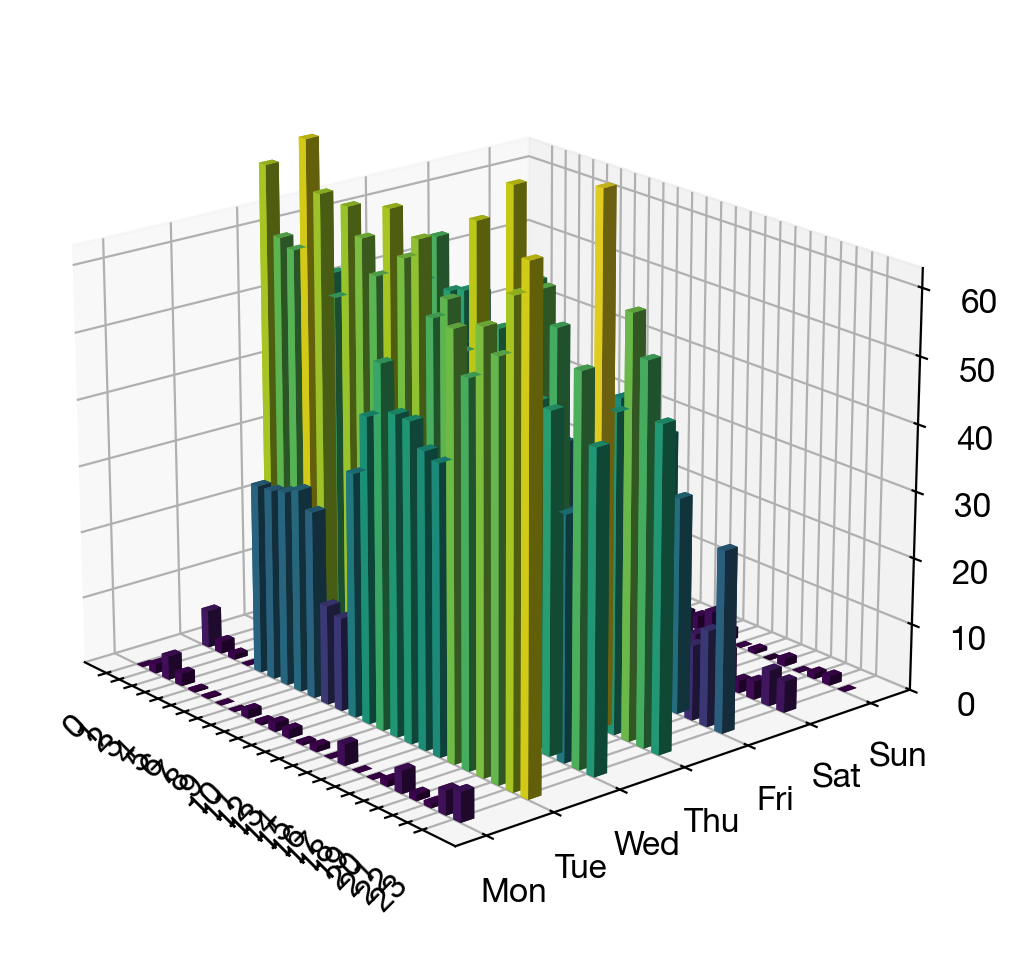

In [1128]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(projection="3d")

ax.bar3d(x_flat, y_flat, 0.0, 0.5, 0.2, z, color=colors)
max_value = np.nanmax(z)
ax.set_zlim(0, max_value * 0.8)

ax.set_xticks(np.arange(len(rows)))
ax.set_xticklabels(rows, rotation=45)  # Rotate for better visibility
ax.set_yticks(np.arange(len(cols)))
ax.set_yticklabels(weekdays);

# style3d(ax, 1.5, 1, 0.8)
ax.view_init(azim=-40, elev=20)

## Research

In [324]:
clocked_hours = data.groupby("project")["seconds"].sum() / 60 ** 2
clocked_hours.sort_values(ascending=False)

project
research          3522.190833
papers             807.381944
learn              625.289722
meeting            258.937778
talks              214.176389
managerial         117.856944
LTCC               117.583056
writings            84.335556
open source         19.560833
Man-internship      16.229167
teaching            10.734722
emails               9.186389
paper-review         4.794722
Qincubator           2.380833
Logs                 1.541111
Name: seconds, dtype: float64

In [98]:
data["project"].unique()

array(['research', 'emails', 'papers', 'meeting', 'LTCC', 'managerial',
       'learn', 'talks', 'Qincubator', 'teaching', 'Man-internship',
       'open source', 'Logs', 'writings', 'paper-review'], dtype=object)

In [709]:
projects_by_hour = data.query("project == 'research'").groupby("description")["seconds"].sum() / 60 ** 2
projects_by_hour.sort_values(ascending=False).head(5)

description
SharpBayes          311.689444
Rebayes             222.861944
thesis — writing    207.598611
shift-happens       152.485833
Hard EM LVM         151.959722
Name: seconds, dtype: float64

In [ ]:
data.query("project == 'papers'").sort_index().tail(10)

In [126]:
data["seconds"].resample("W").sum().div(60 ** 2).tail(20)

start_utc
2024-09-08 00:00:00+00:00    25.840556
2024-09-15 00:00:00+00:00    37.200833
2024-09-22 00:00:00+00:00    37.613611
2024-09-29 00:00:00+00:00    21.789444
2024-10-06 00:00:00+00:00    16.353889
2024-10-13 00:00:00+00:00    29.804167
2024-10-20 00:00:00+00:00    42.053056
2024-10-27 00:00:00+00:00    39.575833
2024-11-03 00:00:00+00:00    43.098889
2024-11-10 00:00:00+00:00    48.062778
2024-11-17 00:00:00+00:00    34.782500
2024-11-24 00:00:00+00:00    35.290833
2024-12-01 00:00:00+00:00    36.445278
2024-12-08 00:00:00+00:00    32.760000
2024-12-15 00:00:00+00:00    43.922778
2024-12-22 00:00:00+00:00    32.893889
2024-12-29 00:00:00+00:00    26.569444
2025-01-05 00:00:00+00:00    24.054167
2025-01-12 00:00:00+00:00    29.781944
2025-01-19 00:00:00+00:00    19.327500
Freq: W-SUN, Name: seconds, dtype: float64

In [127]:
data["seconds"].resample("D").sum().resample("W").mean().tail(20).div(60 ** 2)

start_utc
2024-09-08 00:00:00+00:00    3.691508
2024-09-15 00:00:00+00:00    5.314405
2024-09-22 00:00:00+00:00    5.373373
2024-09-29 00:00:00+00:00    3.112778
2024-10-06 00:00:00+00:00    2.336270
2024-10-13 00:00:00+00:00    4.257738
2024-10-20 00:00:00+00:00    6.007579
2024-10-27 00:00:00+00:00    5.653690
2024-11-03 00:00:00+00:00    6.156984
2024-11-10 00:00:00+00:00    6.866111
2024-11-17 00:00:00+00:00    4.968929
2024-11-24 00:00:00+00:00    5.041548
2024-12-01 00:00:00+00:00    5.206468
2024-12-08 00:00:00+00:00    4.680000
2024-12-15 00:00:00+00:00    6.274683
2024-12-22 00:00:00+00:00    4.699127
2024-12-29 00:00:00+00:00    3.795635
2025-01-05 00:00:00+00:00    3.436310
2025-01-12 00:00:00+00:00    4.254563
2025-01-19 00:00:00+00:00    2.761071
Freq: W-SUN, Name: seconds, dtype: float64

In [ ]:
data.query("project == 'learn'").groupby("description")["seconds"].sum().sort_values(ascending=False) / 60 ** 2

In [ ]:
data.query("project == 'meeting'").groupby("description")["seconds"].sum().sort_values(ascending=False) / 60 ** 2

In [ ]:
data.query("project == 'talks'").groupby("description")["seconds"].sum().sort_values(ascending=False) / 60 ** 2